In [39]:
from typing import List
import pandas as pd
import chess
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from nlpChess.utils.DatasetLoader import loadConcatenatedDataset
ds = loadConcatenatedDataset()
df = ds.to_pandas()

In [40]:
pieces_moves = df[['pieces', 'Moves']]
#concatenate piece to respective moves
def concatenate_pieces_moves(pieces: List[str], moves: List[str]) -> str:
    return ' '.join([f"{piece}{move}" for piece, move in zip(pieces, moves)])

pieces_moves = pieces_moves.apply(
    lambda row: concatenate_pieces_moves(row['pieces'], row['Moves']), axis=1)
pieces_moves_list = pieces_moves.apply(lambda x: x.split())
games = pieces_moves_list.tolist()

In the following cells we are creating the skip grams between a current move and a move with an offset into the future. We collect the skip bigrams and count how often they occure.

In [41]:
from collections import defaultdict
import numpy as np
import pandas as pd


def get_cooccurrence_matrix(moves: List[List[str]], offset: int) -> pd.DataFrame:
    """
    Create a co-occurrence matrix for the given moves with a specified offset.
    
    Args:
        moves (List[List[str]]): List of games, each containing a list of moves.
        offset (int): The offset to consider for co-occurrence.
    
    Returns:
        pd.DataFrame: Co-occurrence matrix.
    """
    co_occurrence = defaultdict(lambda: defaultdict(int))
    
    for game in tqdm(moves):
        for idx, move in enumerate(game):
            neighbor_idx = idx + offset
            if neighbor_idx >= (len(game) - 1):
                break
            neighbor_move = game[neighbor_idx]
            co_occurrence[move][neighbor_move] += 1

    unique_moves = list(sorted(set(m for game in moves for m in game)))
    move_idx_map = {k: v for v, k in enumerate(unique_moves)}
    matrix = np.zeros((len(unique_moves), len(unique_moves)))

    for move, value in tqdm(co_occurrence.items()):
        move_idx = move_idx_map[move]
        for neighbor_move, count in value.items():
            neighbor_move_idx = move_idx_map[neighbor_move]
            matrix[move_idx, neighbor_move_idx] = count
    count_df = pd.DataFrame(matrix, columns=unique_moves, index=unique_moves)
    return count_df
# Example input
offset = 2
count_df = get_cooccurrence_matrix(games, offset)
matrix = count_df.values

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 4075/4075 [00:01<00:00, 3864.57it/s]


Here we would like to know often does any bi-skip-gram occur. Interestingly the count are in general a bit higher if we the next move is a move the the player itself is producing. This will lead to a peakier distribution of entropies (lower standard deviation). We look at this a bit later 

Text(0.5, 1.0, 'Distribution of Skip gram visit counts')

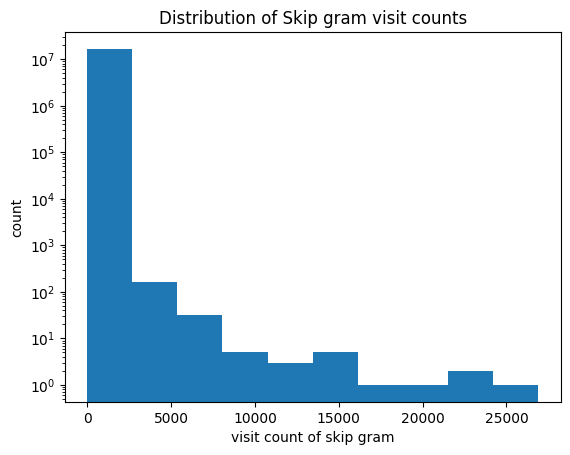

In [42]:
plt.hist(matrix.flatten())
plt.yscale("log")
plt.ylabel("count")
plt.xlabel("visit count of skip gram")
plt.title("Distribution of Skip gram visit counts")

Now we want to plot the count matrix but 1960 by 1960 is to much to see pattern so we only consider only cells which have a move-count over a given threshold and discard all other columns and rows. A orientation for the right threshold can be chosen by looking at the upper plot. 

- A higher threshold corresponds to a smaller matrix (consider less moves)
- A smaller threshold corresponds to a bigger matrix (consider more moves)

An look what we found in the data. It's a rocket! 

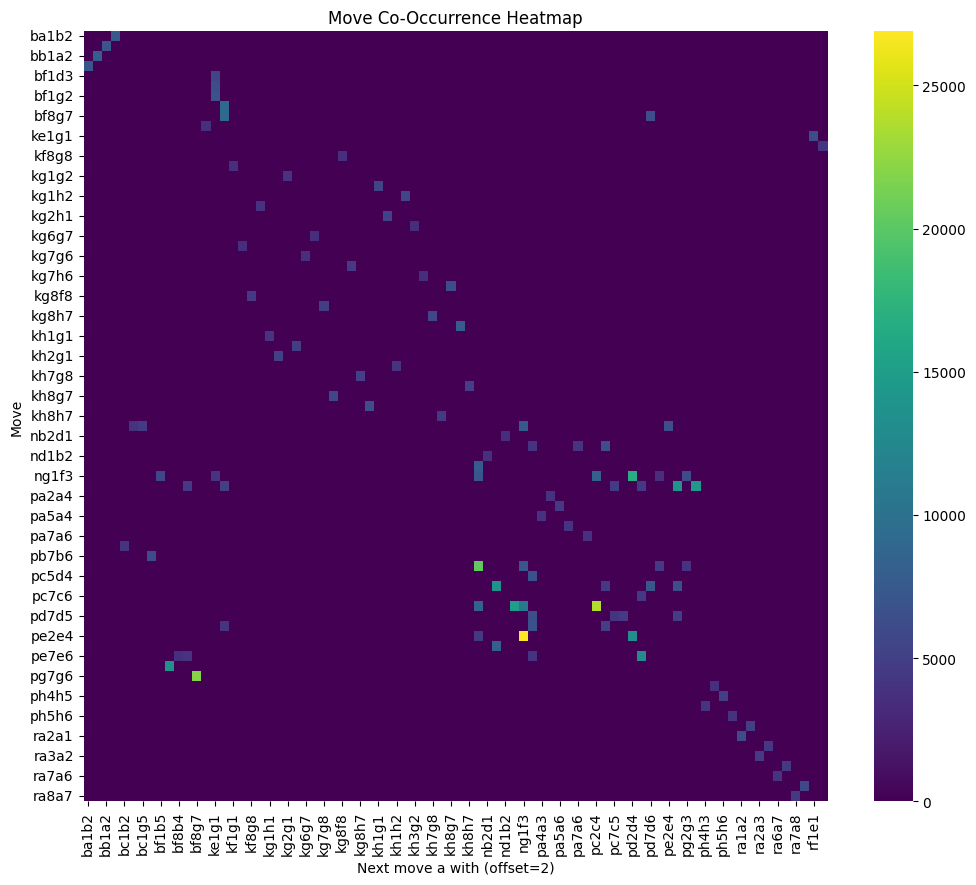

In [28]:
def prune_count_df(count_df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    """
    Prune the count DataFrame by removing rows and columns with counts below a certain threshold.
    
    Args:
        count_df (pd.DataFrame): The count DataFrame to prune.
        threshold (int): The threshold for pruning.
    
    Returns:
        pd.DataFrame: The pruned count DataFrame.
    """
    pruned_df = count_df.copy()
    pruned_df[pruned_df <= threshold] = 0
    pruned_df = pruned_df.drop(pruned_df[pruned_df.sum(axis=1) == 0].index)
    drop_cols = pruned_df.columns[pruned_df.sum(axis=0) == 0]
    pruned_df = pruned_df.drop(columns=drop_cols)
    return pruned_df

mini_df = prune_count_df(count_df, 3500)
# prune rows and columns under a certain count
plt.figure(figsize=(12, 10))
sns.heatmap(mini_df, cmap="viridis")
plt.title("Move Co-Occurrence Heatmap")
plt.ylabel("Move")
plt.xlabel(f"Next move a with ({offset=})")
plt.show()

After reordering the rows and columns according to pairwise similarity (as in a Dendrogram) we get a long diagonal tail for move / next moves bi-skip-grams with the next move proposed by the same player.

Based on this plot we formulate the hypothesis that the move / next moves bi-skip-grams from the same player follow some kind of initial thought or plan and are not as much influenced by the direct opponents move. The influence of the opponents move is visible in the "long" run where the properties of both distributions (odd and even offsets) anneal each-other. This can be also seen in the box plot in the second cell down the line.  

<Figure size 1500x800 with 0 Axes>

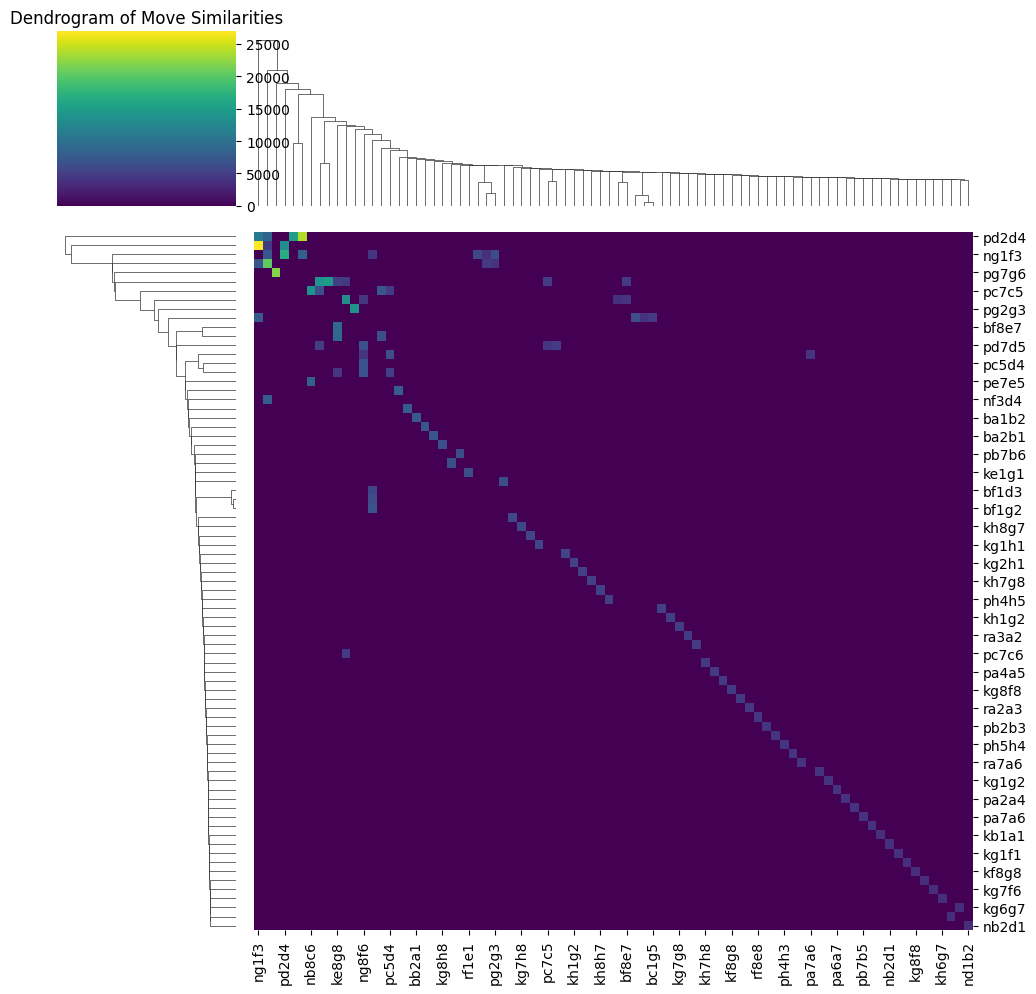

In [29]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Use linkage on the condensed distance matrix
linkage_matrix = linkage(mini_df, method='ward')

plt.figure(figsize=(15, 8))
sns.clustermap(mini_df, cmap="viridis")
plt.title("Dendrogram of Move Similarities")
plt.tight_layout()
plt.show()


Here we plot the distributions of entropy for the next move for all moves. Important to note is that even offset distribution have for small offset values significantly smaller standard deviations indicating a higher certainty about the next move whereas odd offsets (player opponent skip grams) are much more diverse. Both distribution anneal each other while increasing the offset.  

100%|██████████| 1959/1959 [00:00<00:00, 8874.32it/s]
/home/robin/miniconda3/envs/nlp/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 10011.64it/s]
/home/robin/miniconda3/envs/nlp/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 8015.07it/s]
/home/robin/miniconda3/envs/nlp/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 8513.46it/s]
/home/robin/miniconda3/envs/nlp/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<0

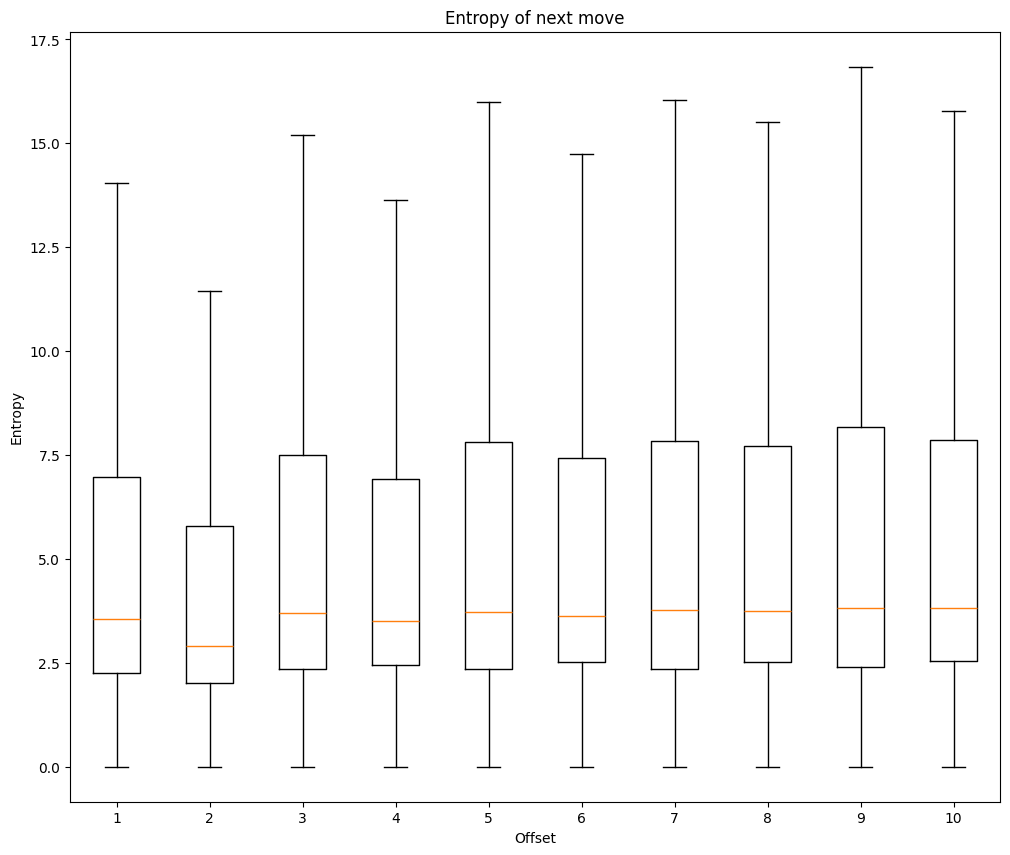

In [30]:
plt.figure(figsize=(12, 10))
bins = np.linspace(0, 40, 101)
for offset in np.arange(1, 11):
    count_df = get_cooccurrence_matrix(moves, offset)
    count_df.sort_index(inplace=True)
    p = count_df / count_df.sum(axis=1)
    entropy = -np.sum(p * np.nan_to_num(np.log(p), copy=True, neginf=0), axis=1)
    plt.boxplot(entropy, positions=[offset], widths=0.5, showfliers=False)
plt.ylabel("Entropy")
plt.xlabel("Offset")
plt.title("Entropy of next move")
plt.show()



Further we have a look which kind piece (pawn, rook, ...) is moved by a certain move. 

In [31]:
data = defaultdict(lambda: defaultdict(int))
for game in tqdm(games):
    for move in game:
        piece = move[0]
        move = move[1:]
        data[piece][move] += 1

df = []
for piece, move_counts in data.items():
    df.append({"piece": piece, **move_counts})
df = pd.DataFrame(df)
df = df.fillna(0)
df = df.set_index("piece")
df.head()

100%|██████████| 100000/100000 [00:03<00:00, 25346.83it/s]


,d2d4,f7f5,g2g3,g7g6,d7d6,c2c3,e7e6,a2a4,e6e5,d4e5,...,e2f1r,c7b8r,b7a8r,f7e8r,b2c1r,f2e1r,g2h1r,f7g8r,b2a1r,g7h8r
piece,,,,,,,,,,,,,,,,,,,,,
p,85841.0,31479.0,50631.0,61414.0,44051.0,29182.0,58331.0,40970.0,25696.0,12965.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7082.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q,3225.0,938.0,715.0,827.0,2664.0,3842.0,3648.0,514.0,2077.0,2640.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k,0.0,0.0,20680.0,21409.0,11086.0,9775.0,14897.0,0.0,13309.0,12665.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are also computing the entropy across the used piece and find two things:

1. A massive spike at entropy = 0: This is caused by promotion moves, which are only executed by pawns so it has to be a point mass. Also moves from a knight are unique in their structures (2 - 1 rule) therefor all moves with a knight have a point-mass.
2. Entropy is a lot less than uniform random. This indicates a nice structure to predict the piece by a move 

/tmp/ipykernel_5330/1516844154.py:2: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(p * np.nan_to_num(np.log2(p), neginf=0), axis=0)


Text(0.5, 1.0, 'Entropy of a move over moved pieces')

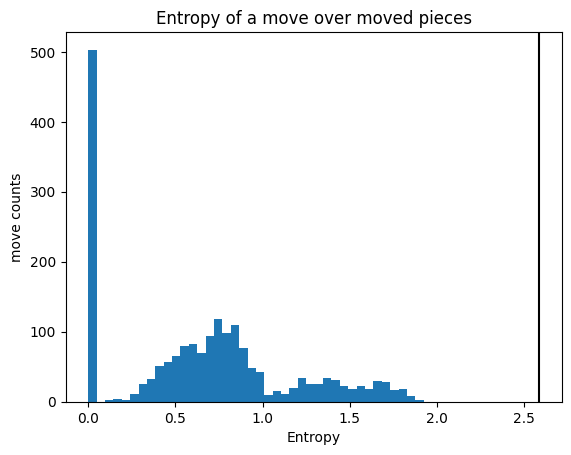

In [32]:
p = df.values / df.values.sum(axis=0)
entropy = -np.sum(p * np.nan_to_num(np.log2(p), neginf=0), axis=0)
plt.hist(entropy, bins=40)
plt.axvline(np.log2(len(df.index)), color="k", label="uniform prediction")
plt.xlabel("Entropy")
plt.ylabel("move counts")
plt.title("Entropy of a move over moved pieces")

We trained a LSTM to predict the piece moved during a game while propagating information about the game in the hidden staten. Although seeing a nice structure in the afore described plot we are struggeling to predict the piece moved during a game. 

In [ ]:
import sys

import torch
sys.path.append("..")
from huggingface_hub import hf_hub_download

# Define model repository and filename
model_name = "ruhrpott/LSTM-chess-piece-1-128"
filename = "model.safetensors"

# Download the checkpoint file
checkpoint_path = hf_hub_download(repo_id=model_name, filename=filename)
print(f"Checkpoint downloaded to: {checkpoint_path}")

from nlpChess.models.BiLSTM import BiLSTM_NER       

model = BiLSTM_NER(100, 128, 6, 1)
from safetensors.torch import load_file

# Load the checkpoint state_dict
state_dict = load_file(checkpoint_path)
model.load_state_dict(load_file(checkpoint_path))

Checkpoint downloaded to: /home/robin/.cache/huggingface/hub/models--ruhrpott--LSTM-chess-piece-1-128/snapshots/61e7cb7da76bf36bdda5786bd0d68f634c802211/model.safetensors


<All keys matched successfully>

In [13]:
from datasets import load_dataset
from nlpChess.dataset.ChessDataset import ChessDataset
ds = load_dataset("PaoloGinefra03/ChessGamesForNlp", split="test")
ds = ChessDataset(dataset=ds, inputColumns=["Moves"], labelColumns=["pieces"])

Loading dataset with columns  ['Moves', 'pieces']
Loaded 10001 rows and 2 columns


Converting columns to indices: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


An exemplary game a index 0 has the piece prediction as displayed in the heatmap. The model is committing to a piece almost all the time but usually the wrong one. The prediction are usually on point for the first couple of moves but after that it almost appears as the model looses track of what is happening and the positions of the peaces such that it provides almost all of the time the wrong prediction. 

Please feel free to play around with the `idx` variable to predict the moved piece for a different game. 

In [ ]:
import torch
idx = 0
with torch.no_grad():
    x, y = ds[idx]
    out, hidden = model.forward(x[0][None])
print(ds.getLabelLookupTables()["pieces"])
plt.matshow(out.T)
plt.scatter(torch.arange(len(out)), y[0] -1, s=4)
plt.scatter(torch.arange(len(out))[y[0] == 2], y[0][y[0] == 2] -1, s=4)
plt.yticks(np.arange(len(ds.getLabelLookupTables()["pieces"])), ds.getLabelLookupTables()["pieces"].keys())
plt.ylabel("pieces")
plt.xlabel("move number")
plt.title(f"Prediction of moved pieces over game={idx}")

ValueError: input must have the type torch.float32, got type torch.int64

In [36]:
preds = []
labels = []
for x, y in tqdm(ds):
    with torch.no_grad():
        preds.append(model.forward(x[0])) 
        labels.append(y)

100%|██████████| 10001/10001 [02:50<00:00, 58.75it/s]


In [37]:
import numpy as np

cross_entropies = []
for (pred, _), (label,) in zip(preds, labels):
    cross_entropies.append(-np.nan_to_num(torch.log(pred), neginf=0)[torch.arange(len(pred)), label - 1])

Because formulating a hypothesis on a single prediction is a bit pointless we compute the cross entropy (between target piece distribution and predicted piece distribution). And we can see a low cross entropy for the first couple of moves which rises and plateaus quickly. The high frequency noise in the end is due to less available games which endure so long

Text(0.5, 1.0, 'Crossentropy between target and predicted piece distribution.')

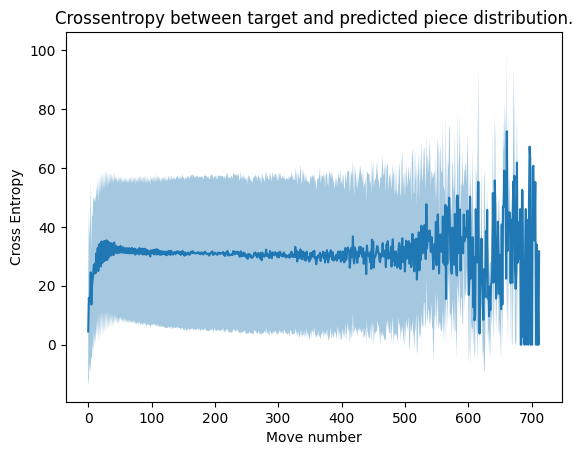

In [38]:
max_len = max(list(map(lambda x: len(x[0]), preds)))

res = []
for ce in cross_entropies:
    if (max_len - len(ce)) > 0:
        res.append(np.concatenate([ce, -np.ones(max_len - len(ce))]))
    else:
        res.append(ce)
res = np.stack(res)
mean = np.mean(res, axis=0, where=res > -1)
std =  np.std(res, axis=0, where=res > -1)
plt.fill_between(np.arange(res.shape[1]), mean-std, mean + std, alpha=0.4)
plt.plot(mean)
plt.xlabel("Move number")
plt.ylabel("Cross Entropy")
plt.title("Crossentropy between target and predicted piece distribution.")